# Python Script for:
# Exploring the Health Landscape in IS Research: A Text-Mining Analysis

## Accepted at: Electronic Markets

## Publication year: 2025

### Paper Authors: Silke Weißenfels, Anika Nissen & Stefan Smolnik

Script by &copy; Anika Nissen

Language models used in this script:

* topic modelling: spacy library with the ``en_core_web_trf`` model. 

In [1]:
#import importlib

# Import all of the required libs
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# This provides us the nlp pipeline for tokenization and pre-trained language models as well as sentiment analysis
import spacy
import spacy_transformers

#from spacytextblob.spacytextblob import SpacyTextBlob
#import en_core_web_sd
#import en_core_web_md

# Additional imports for ngrams
import nltk
from nltk import ngrams
from nltk.corpus import stopwords

# This provides the actual models that are used to create the different topics
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf as GensimNmf

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data and get an impression on the data structure

In [2]:
#Import data and have a look at data

reports = pd.read_excel("SLR-Health-inBasket11-v3.xlsx")
reports.head()

,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant
0,"Hu P.J., Chau P.Y.K., Liu Sheng O.R., Tam K.Y.",Examining the Technology Acceptance Model Usin...,1999,Journal of Management Information Systems,1264.0,10.1080/07421222.1999.11518247,The rapid growth of investment in information ...,1,0,yes
1,"Ray G., Muhanna W.A., Barney J.B.",Information technology and the performance of ...,2005,MIS Quarterly: Management Information Systems,760.0,10.2307/25148703,Delivering quality customer service has emerge...,1,0,yes
2,"Yi M.Y., Jackson J.D., Park J.S., Probst J.C.",Understanding information technology acceptanc...,2006,Information and Management,736.0,10.1016/j.im.2005.08.006,Although information technology is becoming a ...,1,0,yes
3,"Angst C.M., Agarwal R.",Adoption of electronic health records in the p...,2009,MIS Quarterly: Management Information Systems,731.0,10.2307/20650295,Within the emerging context of the digitizatio...,1,1,yes
4,"Chau P.Y.K., Hu P.J.-H.",Investigating healthcare professionals' decisi...,2002,Information and Management,705.0,10.1016/S0378-7206(01)00098-2,The proliferation of information technology (I...,0,1,yes


In [3]:
# Get info on the data structure
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Authors             495 non-null    object 
 1   Title               495 non-null    object 
 2   Year                495 non-null    int64  
 3   Source              495 non-null    object 
 4   Cited By            447 non-null    float64
 5   DOI                 493 non-null    object 
 6   Abstract            488 non-null    object 
 7   Health in Abstract  495 non-null    int64  
 8   Health in Title     495 non-null    int64  
 9   Relevant            495 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 38.8+ KB


In [4]:
print(reports['Abstract'][5])

Reluctance to provide personal health information could impede the success of web-based healthcare services. This paper focuses on the role of personal dispositions in disclosing health information online. The conceptual model argues that individuals' intention to disclose such information depends on their trust, privacy concern, and information sensitivity, which are determined by personal dispositions-personality traits, information sensitivity, health status, prior privacy invasions, risk beliefs, and experience-acting as intrinsic antecedents of trust. The data (collected via a lab experiment) and the analysis shed light on the role of personal dispositions. This could assist in enhancing healthcare websites and increase the success of online delivery of health services. © 2010 Elsevier B.V. All rights reserved.


In [5]:
#Delete everything after the Copyright sign which is often added by several publishers
reports['Abstract-clean'] = reports['Abstract'].str.split('©').str[0]
print(reports['Abstract-clean'][5])

Reluctance to provide personal health information could impede the success of web-based healthcare services. This paper focuses on the role of personal dispositions in disclosing health information online. The conceptual model argues that individuals' intention to disclose such information depends on their trust, privacy concern, and information sensitivity, which are determined by personal dispositions-personality traits, information sensitivity, health status, prior privacy invasions, risk beliefs, and experience-acting as intrinsic antecedents of trust. The data (collected via a lab experiment) and the analysis shed light on the role of personal dispositions. This could assist in enhancing healthcare websites and increase the success of online delivery of health services. 


In [6]:
# Then feed everything back into the original Abstract column and format as string:
reports['Abstract']= reports['Abstract-clean'].astype(str)
reports['Abstract'].head()

0    The rapid growth of investment in information ...
1    Delivering quality customer service has emerge...
2    Although information technology is becoming a ...
3    Within the emerging context of the digitizatio...
4    The proliferation of information technology (I...
Name: Abstract, dtype: object

# Topic Models based on the Papers' Abstracts

## Text tokenization

First load the pre-trained language model from spacy library and then i) clean, stem and tokenize the text, ii) go through bigrams and trigrams and add them to list of tokens

In [7]:
# load the language model and add the sentiment analyzer to it:
nlp = spacy.load('en_core_web_trf')

In [8]:
spacy.explain('ADJ')

'adjective'

In [9]:
# Tags I want to remove from the text
removal= ['PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM', 'VERB']
keep = ['NOUN', 'PROPN']
tokens = []


# Looping through text to tokenize the whole thing
for summary in nlp.pipe(reports['Abstract']):
    proj_tok = [token.lemma_.lower() for token in summary 
                if token.pos_ in keep and token.is_alpha]
#                if token.pos_ not in removal and not token.is_stop and token.is_alpha] # and not token.is_stop
    tokens.append(proj_tok)

In [10]:
doc = nlp(reports['Abstract'][1])

print(f"{'text':{8}} {'POS':{6}} {'TAG':{6}} {'Dep':{6}} {'POS explained':{20}} {'tag explained'} ")

for token in doc:
    print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}} {token.dep_:{6}} {spacy.explain(token.pos_):{20}} {spacy.explain(token.tag_)}')

text     POS    TAG    Dep    POS explained        tag explained 
Delivering VERB   VBG    csubj  verb                 verb, gerund or present participle
quality  ADJ    JJ     amod   adjective            adjective (English), other noun-modifier (Chinese)
customer NOUN   NN     compound noun                 noun, singular or mass
service  NOUN   NN     dobj   noun                 noun, singular or mass
has      AUX    VBZ    aux    auxiliary            verb, 3rd person singular present
emerged  VERB   VBN    ROOT   verb                 verb, past participle
as       ADP    IN     prep   adposition           conjunction, subordinating or preposition
a        DET    DT     det    determiner           determiner
strategic ADJ    JJ     amod   adjective            adjective (English), other noun-modifier (Chinese)
imperative NOUN   NN     pobj   noun                 noun, singular or mass
,        PUNCT  ,      punct  punctuation          punctuation mark, comma
one      NUM    CD     appo

In [11]:
cleaned_tokens = tokens

for j in range(len(cleaned_tokens)):
    for i in cleaned_tokens[j]:
            if len(i) < 2:
                cleaned_tokens[j].remove(i)

cleaned_tokens[:2]

[['growth',
  'investment',
  'information',
  'technology',
  'it',
  'organization',
  'user',
  'acceptance',
  'technology',
  'implementation',
  'management',
  'issue',
  'acceptance',
  'attention',
  'research',
  'effort',
  'research',
  'result',
  'technology',
  'user',
  'population',
  'context',
  'response',
  'paper',
  'research',
  'work',
  'applicability',
  'technology',
  'acceptance',
  'model',
  'tam',
  'physician',
  'decision',
  'telemedicine',
  'technology',
  'health',
  'care',
  'context',
  'technology',
  'user',
  'group',
  'context',
  'it',
  'acceptance',
  'adoption',
  'research',
  'study',
  'technology',
  'management',
  'need',
  'million',
  'dollar',
  'healthcare',
  'organization',
  'telemedicine',
  'program',
  'year',
  'model',
  'fit',
  'power',
  'link',
  'acceptance',
  'technology',
  'physician',
  'hospital',
  'hong',
  'kong',
  'result',
  'tam',
  'depiction',
  'physician',
  'intention',
  'telemedicine',
  'tech

In [12]:
tokenlist = sum(cleaned_tokens, [])

# Clean and Lemmatize Abstracts

In [13]:
# Extract bigrams and trigrams from text
bigramseries = (pd.Series(nltk.ngrams(tokenlist, 2)).value_counts())
s = bigramseries.to_frame()

s.reset_index(inplace=True)
s = s.rename(columns = {'index':'bigrams', 0: 'frequency'})    
    
trigramseries = (pd.Series(nltk.ngrams(tokenlist, 3)).value_counts())
t = trigramseries.to_frame()

t.reset_index(inplace=True)
t = t.rename(columns = {'index':'trigrams', 0: 'frequency'})    
    
    
# Now let's feed the bigrams and trigrams back into the list of tokens 
# after filtering for unigrams
bigrams = s['bigrams'].tolist()
bi = []

for words in bigrams:
    bi2 = ' '.join(words)
    bi.append(bi2)

trigrams = t['trigrams'].tolist()
tri = []

for words in trigrams:
    tri2 = ' '.join(words)
    tri.append(tri2)
    
ngrams = bi+ tri

## Let's not rely on unigrams only but also include the used brigrams and trigrams as well

In [14]:
i = 0
for summary in reports['Abstract']:
    for gram in ngrams:
        if gram in summary:
            cleaned_tokens[i].append(gram)
    i = i+1  

In [15]:
ngramtok = []
for summary in reports['Abstract']:
    row = []
    for gram in ngrams:
        if gram in summary:
            row.append(gram)
    ngramtok.append(row)
    
ngramtok[:2]   

[['information technology',
  'healthcare organization',
  'technology acceptance',
  'acceptance model',
  'user technology',
  'care organization',
  'research result',
  'telemedicine technology',
  'user group',
  'study finding',
  'user acceptance',
  'adoption research',
  'technology implementation',
  'his paper',
  'care context',
  'management issue',
  'research work',
  'technology management',
  'us research',
  'option research',
  'telemedicine management',
  'acceptance research',
  'management need',
  'user population',
  'telemedicine program',
  'need re',
  'use telemedicine',
  'user technology acceptance',
  'technology acceptance research',
  'technology management need'],
 ['information system',
  'information technology',
  'information systems',
  'health insurance',
  'customer service',
  'performance effect',
  'process performance',
  'service process',
  'his paper',
  'technology resource',
  'insurance industry',
  'service unit',
  'quality customer'

In [18]:
# Let's remove the most frequent bigrams and trigrams from our token list so that they don't 
# override the different facets in the corpus

removebigrams = s['bigrams'][:30].tolist()
rb = []

for words in removebigrams:
    rb2 = ' '.join(words)
    rb.append(rb2)

removetrigrams = t['trigrams'][:30].tolist()
rt = []

for words in removetrigrams:
    rt2 = ' '.join(words)
    rt.append(rt2)    
    
removengrams = rb + rt
removengrams[:3]

['information system', 'health information', 'information technology']

## Let's Explore the Most Used Terms in the Papers

In [19]:
removetokens = ['his paper', "al healthcare", "er patient", "al framework", "use p", "model is", "is research", 
                "his research", "information systems", "information technologies", 'research co', 'er patient', 
                "panel data", "data analytics", "support vector", "vector machine", "system us", "model base", 
                "research model", "outcome expectation", "ed resource", "future research", "study use", 
                "systems research", "study is", "systems is", "making process", "research focus", "us research",
               'need re', 'research result', 'study finding',
                "information systems research", "work is", "care context", "care industry", "care service", 
                "care policy", "performance effect", "care system", "management information", "management information system",
                "electronic health", "science paradigm", "design science paradigm", "level health", 
                "action research effort", "se se", "change theory", "research problem", "electronic medical", 
                "care setting", "paper address", "paper investigate", "his context", #round 1
                'level is', 'ed service', 'care information', 'year period', 'care environment',
                "care organization", "delivery systems", "science research", "care delivery", 
                "information is", "care cost", "patient no", "data source", "data set", 
                "care quality", "care provider", "approach is", "individual us", "care quality", 
                "is article", "is use", "care sector", "case is", "care practice", "research avenue",
                "data collection", "care practitioner", "care outcome", "care delivery", "is need",
                "research is", "online health", "user group", "research work", "option research", # round 2
                'ed role', 'learning technique', 'care decision', 'record system', 
                'us information', 'us information system', 'artificial neural', 'research project',
                'paper de', "health records", "electronic health records", "research approach",
                "care facility", "study focus", "research framework", "us issue", "care organisation", 
                "process is", #round 3
                'source software', "us patient", "level analysis", "cognitive theory", "social cognitive", 
                "field study", "care community", "case analysis", "effect is", "research challenge",
                "medical record", "research question", "ict health", # round 4
                "record systems", "health record systems", "enterprise information", "likelihood model",
                "elaboration likelihood", "formation process", "research method", "equation model",
                "rate health", "rate healthcare", "care situation", "data envelopment", 
                "information systems is", "exchange theory", "social exchange", # round 5
                'future health', "quality health", "is theory", "care management",
                "care service delivery", "it it", "envelopment analysis", "level structure", 
                "is challenge", "cost economic", #round 6
                "healthcare environment", "rate information", "care worker", "healthcare setting", 
                "neural networks", "boundary condition", "field experiment", "design science",
                "healthcare context" #round 7
                "care reform", "potential solution", "discourse analysis", "level information",
                "action problem", "health application", "technology co", "time period",
                "rating it", "healthcare research", "care research", "care platform", 
                "process lead", "change process", "assessment method", "management system",
                "ed nature", "healthcare sector", "health sector", 'panel data',
                'design research', 'action design', 'content analysis', 'his need', 'care delivery systems', #round 8
                "al choice", "al physician", "citation analysis", "ems literature", #round 9
                "recent year", "system is", "other hand", "previous research", "proposed approach",
                "further research", "same time", "different level", "significant impact",
                "es such", "important implication", "little research", "such system",
                "significant role", "important role", "prior research", "further research", 
                "new insight", "proposed approach", "system is", "different level", "little research",
                "medical practices", "important implication"
               ] # additional ngrams we want to remove

for i in ngramtok:
    for j in range(len(i) -1, -1, -1):
        if i[j] in removengrams:
            del i[j];

for i in ngramtok:
    for j in range(len(i) -1, -1, -1):
        if i[j] in removetokens:
            del i[j];            
            
            
ngramtok[:1]

[['acceptance model',
  'user technology',
  'telemedicine technology',
  'user acceptance',
  'adoption research',
  'technology implementation',
  'management issue',
  'technology management',
  'telemedicine management',
  'acceptance research',
  'management need',
  'user population',
  'telemedicine program',
  'use telemedicine',
  'user technology acceptance',
  'technology acceptance research',
  'technology management need']]

### Clean the tokens 

In [20]:
reports['tokfunc1'] = ngramtok
reports['tokfunc1'].head()

0    [acceptance model, user technology, telemedici...
1    [health insurance, customer service, process p...
2    [acceptance model, user acceptance, acceptance...
3    [healthcare delivery, privacy concern, informa...
4    [acceptance model, telemedicine technology, bu...
Name: tokfunc1, dtype: object

### Create dictionary & select number of topics
calculate topic coherence through 1 < n < 31 number of topics to select the optimum

In [21]:
# Create dictionary and corpus for LDA model:
dictionary = Dictionary(reports['tokfunc1'])

#Option --> filter extremes: less than 2%, more than 60%, keep all tokens
#dictionary.filter_extremes(no_above=0.95)

corpus = [dictionary.doc2bow(doc) for doc in reports['tokfunc1']]

In [22]:
print(len(dictionary))

3991


In [23]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Coherence Score C_V to Select Number of Topics

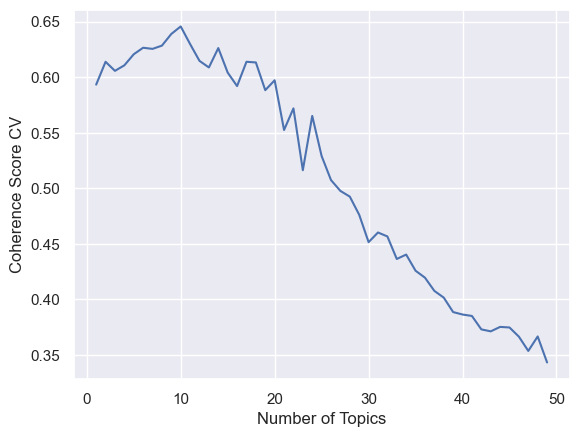

In [24]:
#Calculating the coherence score using C_v
topics_cv = []
score_cv = []
for i in range(1,50,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = reports['tokfunc1'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics_cv.append(i)
    score_cv.append(cm.get_coherence())
_=plt.plot(topics_cv, score_cv)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score CV')
plt.show()

In [25]:
coherence_v = pd.DataFrame({'Number of Topics': topics_cv,
                               'Coherence Score': score_cv})
coherence_v['Sorted'] = coherence_v['Coherence Score'].abs()
coherence_v.sort_values(by=['Sorted'], ascending = False).head(10)

,Number of Topics,Coherence Score,Sorted
9,10,0.645625,0.645625
8,9,0.638885,0.638885
10,11,0.629769,0.629769
7,8,0.628372,0.628372
5,6,0.626464,0.626464
13,14,0.626174,0.626174
6,7,0.625443,0.625443
4,5,0.620612,0.620612
11,12,0.614640,0.614640
16,17,0.613844,0.613844


### Run the final model 

In [37]:
# Run the model and look at the topics generated:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, 
                         num_topics=10, workers = 8, passes=20)

lda_model.print_topics()

[(0,
  '0.006*"health communities" + 0.005*"electronic health record" + 0.003*"data analytic" + 0.003*"healthcare practice" + 0.003*"online health communities" + 0.003*"social exchange theory" + 0.003*"policy maker" + 0.002*"patient satisfaction" + 0.002*"healthcare cost" + 0.002*"mobile health"'),
 (1,
  '0.005*"electronic health record" + 0.004*"public health" + 0.004*"health services" + 0.004*"health information systems" + 0.003*"information privacy" + 0.003*"health policy" + 0.003*"action research" + 0.003*"health communities" + 0.003*"data breach" + 0.002*"work practice"'),
 (2,
  '0.004*"public health" + 0.004*"healthcare need" + 0.002*"health status" + 0.002*"healthcare delivery" + 0.002*"treatment plan" + 0.002*"electronic medical record" + 0.002*"machine learning" + 0.002*"healthcare stakeholder" + 0.002*"medical center" + 0.002*"healthcare resource"'),
 (3,
  '0.005*"healthcare delivery" + 0.004*"healthcare cost" + 0.004*"delivery system" + 0.003*"health information systems" 

### Merge the topics into dataframe and export as Excel

In [38]:
from gensim import matutils

all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

In [39]:
merged = pd.merge(left=reports, left_index=True,
                  right=all_topics_df, right_index=True,
                  how='inner')
merged.head()

,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,0,1,2,3,4,5,6,7,8,9
0,"Hu P.J., Chau P.Y.K., Liu Sheng O.R., Tam K.Y.",Examining the Technology Acceptance Model Usin...,1999,Journal of Management Information Systems,1264.0,10.1080/07421222.1999.11518247,The rapid growth of investment in information ...,1,0,yes,...,0.005557,0.949989,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557
1,"Ray G., Muhanna W.A., Barney J.B.",Information technology and the performance of ...,2005,MIS Quarterly: Management Information Systems,760.0,10.2307/25148703,Delivering quality customer service has emerge...,1,0,yes,...,0.007144,0.935703,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144
2,"Yi M.Y., Jackson J.D., Park J.S., Probst J.C.",Understanding information technology acceptanc...,2006,Information and Management,736.0,10.1016/j.im.2005.08.006,Although information technology is becoming a ...,1,0,yes,...,0.011112,0.011113,0.011113,0.011113,0.011112,0.011113,0.011113,0.011112,0.899986,0.011113
3,"Angst C.M., Agarwal R.",Adoption of electronic health records in the p...,2009,MIS Quarterly: Management Information Systems,731.0,10.2307/20650295,Within the emerging context of the digitizatio...,1,1,yes,...,0.006668,0.006669,0.006668,0.006669,0.939985,0.006668,0.006668,0.006668,0.006668,0.006669
4,"Chau P.Y.K., Hu P.J.-H.",Investigating healthcare professionals' decisi...,2002,Information and Management,705.0,10.1016/S0378-7206(01)00098-2,The proliferation of information technology (I...,0,1,yes,...,0.009093,0.009093,0.009093,0.009093,0.009093,0.009093,0.918163,0.009093,0.009094,0.009093


In [40]:
merged.to_excel("Merged LDA Probability_v4.xlsx")

In [41]:
list(merged.columns.values).index(0)

12

In [42]:
merged.iloc[:,12:35]

,0,1,2,3,4,5,6,7,8,9
0,0.005557,0.949989,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557
1,0.007144,0.935703,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144
2,0.011112,0.011113,0.011113,0.011113,0.011112,0.011113,0.011113,0.011112,0.899986,0.011113
3,0.006668,0.006669,0.006668,0.006669,0.939985,0.006668,0.006668,0.006668,0.006668,0.006669
4,0.009093,0.009093,0.009093,0.009093,0.009093,0.009093,0.918163,0.009093,0.009094,0.009093
...,...,...,...,...,...,...,...,...,...,...
490,0.005883,0.005883,0.947050,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883
491,0.004001,0.004001,0.004001,0.004001,0.004001,0.004001,0.963992,0.004001,0.004001,0.004001
492,0.006668,0.006668,0.939989,0.006668,0.006668,0.006668,0.006668,0.006668,0.006668,0.006668
493,0.943737,0.006251,0.006251,0.006251,0.006251,0.006251,0.006252,0.006252,0.006251,0.006252


In [43]:
# first let's get the topic that is most probable for each abstract:
merged['Topic_ID'] = merged.iloc[:,12:35].idxmax(axis=1)
merged.iloc[:,12:35]

,0,1,2,3,4,5,6,7,8,9,Topic_ID
0,0.005557,0.949989,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,1
1,0.007144,0.935703,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,1
2,0.011112,0.011113,0.011113,0.011113,0.011112,0.011113,0.011113,0.011112,0.899986,0.011113,8
3,0.006668,0.006669,0.006668,0.006669,0.939985,0.006668,0.006668,0.006668,0.006668,0.006669,4
4,0.009093,0.009093,0.009093,0.009093,0.009093,0.009093,0.918163,0.009093,0.009094,0.009093,6
...,...,...,...,...,...,...,...,...,...,...,...
490,0.005883,0.005883,0.947050,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,2
491,0.004001,0.004001,0.004001,0.004001,0.004001,0.004001,0.963992,0.004001,0.004001,0.004001,6
492,0.006668,0.006668,0.939989,0.006668,0.006668,0.006668,0.006668,0.006668,0.006668,0.006668,2
493,0.943737,0.006251,0.006251,0.006251,0.006251,0.006251,0.006252,0.006252,0.006251,0.006252,0


In [44]:
data = lda_model.show_topics(formatted=True, num_words= 10, num_topics=10)
df = pd.DataFrame(data, columns = ['index', 'topics'])
df = df.replace('[^a-zA-Z+]',' ', regex=True)
df

,index,topics
0,0,health communities + electronic...
1,1,electronic health record + publ...
2,2,public health + healthcare need...
3,3,healthcare delivery + healthcar...
4,4,electronic medical record + hea...
5,5,health services + electronic me...
6,6,electronic health record + publ...
7,7,mental health + healthcare cost...
8,8,health system + decision maker ...
9,9,electronic health record + heal...


In [45]:
merged2 = merged
merged2["Topic Description"] = merged2["Topic_ID"]
for i in df['index']:
    merged2.loc[merged2['Topic_ID'] == i, 'Topic Description'] = df.iloc[i]['topics']

merged2.to_excel('./LDATopicResults_v4.xlsx', index = True, header=True)

## Because the LDA Model Topics are Hard to Interpret, We Will Use NMF Instead


In [56]:
import numpy as np

import statistics as stats

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans

In [57]:
#reports['Abstract']= reports['Abstract'].astype(str)
abstract = reports['Abstract-clean']
abstract.fillna("",inplace=True)

In [58]:
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(abstract)
tfidf_feature_names = tfidf.get_feature_names_out()

In [59]:
no_topics = 10 #selected from LDA topics above

# Run NMF
nmf = NMF(n_components=no_topics).fit(X_tfidf)

In [60]:
import numpy as np

In [61]:
#extract topics
def display_topics(model, feature_names, no_top_words):
    topics=[]
    for topic_idx, topic in enumerate(model.components_):
        #rint ("Topic %d:" % (topic_idx))
        topic_words=" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        #rint(topic_words)
        topics.append(topic_words)
    return topics

no_top_words = 10
#rint("NMF: ")
topics_nmf=display_topics(nmf, tfidf_feature_names, no_top_words)


#rint(topics_nmf)
#rint(topics_lda)

pred_nmf=nmf.transform(X_tfidf)

res_nmf=[topics_nmf[np.argmax(r)] for r in pred_nmf]

merged2['topic_nmf']=res_nmf

In [63]:
grouped=merged2.groupby('topic_nmf')
for gp_name, gp in grouped:
    display(gp)

,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
0,"Hu P.J., Chau P.Y.K., Liu Sheng O.R., Tam K.Y.",Examining the Technology Acceptance Model Usin...,1999,Journal of Management Information Systems,1264.0,10.1080/07421222.1999.11518247,The rapid growth of investment in information ...,1,0,yes,...,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,1,electronic health record + publ...,acceptance technology adoption model perceived...
2,"Yi M.Y., Jackson J.D., Park J.S., Probst J.C.",Understanding information technology acceptanc...,2006,Information and Management,736.0,10.1016/j.im.2005.08.006,Although information technology is becoming a ...,1,0,yes,...,0.011113,0.011112,0.011113,0.011113,0.011112,0.899986,0.011113,8,health system + decision maker ...,acceptance technology adoption model perceived...
4,"Chau P.Y.K., Hu P.J.-H.",Investigating healthcare professionals' decisi...,2002,Information and Management,705.0,10.1016/S0378-7206(01)00098-2,The proliferation of information technology (I...,0,1,yes,...,0.009093,0.009093,0.009093,0.918163,0.009093,0.009094,0.009093,6,electronic health record + publ...,acceptance technology adoption model perceived...
8,"Bhattacherjee A., Hikmet N.",Physicians' resistance toward healthcare infor...,2007,European Journal of Information Systems,428.0,10.1057/palgrave.ejis.3000717,This paper presents a theoretical model of phy...,1,1,yes,...,0.006668,0.939989,0.006668,0.006668,0.006668,0.006668,0.006668,4,electronic medical record + hea...,acceptance technology adoption model perceived...
15,"Wu I.-L., Li J.-Y., Fu C.-Y.",The adoption of mobile healthcare by hospital'...,2011,Decision Support Systems,288.0,10.1016/j.dss.2011.03.003,The adoption rate of mobile healthcare is rela...,1,1,yes,...,0.016670,0.016673,0.016669,0.016674,0.849961,0.016669,0.016673,7,mental health + healthcare cost...,acceptance technology adoption model perceived...
25,"Walter Z., Lopez M.S.",Physician acceptance of information technologi...,2008,Decision Support Systems,204.0,10.1016/j.dss.2008.06.004,Physician acceptance of clinical information t...,1,0,yes,...,0.020003,0.819972,0.020003,0.020003,0.020003,0.020005,0.020003,4,electronic medical record + hea...,acceptance technology adoption model perceived...
31,"Lee C.-P., Shim J.P.",An exploratory study of radio frequency identi...,2007,European Journal of Information Systems,186.0,10.1057/palgrave.ejis.3000716,This study examines the radio frequency identi...,1,1,yes,...,0.924987,0.008335,0.008336,0.008335,0.008335,0.008335,0.008335,3,healthcare delivery + healthcar...,acceptance technology adoption model perceived...
43,"Khoumbati K., Themistocleous M., Irani Z.",Evaluating the adoption of enterprise applicat...,2006,Journal of Management Information Systems,155.0,10.2753/MIS0742-1222220404,The integration of heterogeneous information s...,1,1,yes,...,0.010002,0.010002,0.010002,0.010003,0.010003,0.010002,0.909979,9,electronic health record + heal...,acceptance technology adoption model perceived...
46,"Lu M.-T., Lin S.-W., Tzeng G.-H.",Improving RFID adoption in Taiwan's healthcare...,2013,Decision Support Systems,146.0,10.1016/j.dss.2013.06.006,The use of radio frequency identification (RFI...,1,1,yes,...,0.007694,0.007694,0.930757,0.007694,0.007693,0.007694,0.007693,5,health services + electronic me...,acceptance technology adoption model perceived...
72,Moores T.T.,Towards an integrated model of IT acceptance i...,2012,Decision Support Systems,100.0,10.1016/j.dss.2012.04.014,We develop and test an integrated model of IT ...,0,1,yes,...,0.887472,0.012502,0.012503,0.012503,0.012502,0.012504,0.012503,3,healthcare delivery + healthcar...,acceptance technology adoption model perceived...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
12,"Strong D.M., Volkoff O., Johnson S.A., Pelleti...",A theory of organization-EHR affordance actual...,2014,Journal of the Association for Information Sys...,335.0,10.17705/1jais.00353,While organizations implement information tech...,1,0,yes,...,0.009093,0.009093,0.918162,0.009093,0.009092,0.009092,0.009094,5,health services + electronic me...,ehr hospitals ehrs use data quality electronic...
30,"Venkatesh V., Zhang X., Sykes T.A.","""Doctors do too little technology"": A longitud...",2011,Information Systems Research,187.0,10.1287/isre.1110.0383,With the strong ongoing push toward investment...,1,1,yes,...,0.007694,0.007694,0.007695,0.007694,0.007694,0.930753,0.007694,8,health system + decision maker ...,ehr hospitals ehrs use data quality electronic...
55,"Kohli R., Tan S.S.-L.",Electronic health records: How can is research...,2016,MIS Quarterly: Management Information Systems,127.0,10.25300/MISQ/2016/40.3.02,Electronic health records (EHR) facilitate int...,1,1,yes,...,0.016671,0.016671,0.016671,0.016672,0.016670,0.016670,0.016671,1,electronic health record + publ...,ehr hospitals ehrs use data quality electronic...
56,"Chang I.-C., Hwang H.-G., Hung M.-C., Lin M.-H...",Factors affecting the adoption of electronic s...,2007,Decision Support Systems,126.0,10.1016/j.dss.2007.04.006,The healthcare industry is experiencing a majo...,1,0,yes,...,0.014288,0.014289,0.014287,0.014288,0.014287,0.014288,0.014288,2,public health + healthcare need...,ehr hospitals ehrs use data quality electronic...
57,"Burton-Jones A., Volkoff O.",How can we develop contextualized theories of ...,2017,Information Systems Research,126.0,10.1287/isre.2017.0702,We contribute to the shifting discourse in the...,1,1,yes,...,0.014289,0.871400,0.014290,0.014288,0.014289,0.014289,0.014288,4,electronic medical record + hea...,ehr hospitals ehrs use data quality electronic...
63,"Bradley R.V., Pratt R.M.E., Byrd T.A., Outlay ...","Enterprise architecture, IT effectiveness and ...",2012,Information Systems Journal,121.0,10.1111/j.1365-2575.2011.00379.x,Despite the possible benefits of implementing ...,1,0,yes,...,0.011113,0.011114,0.011113,0.899980,0.011113,0.011113,0.011113,6,electronic health record + publ...,ehr hospitals ehrs use data quality electronic...
71,"Mishra A.N., Anderson C., Angst C.M., Agarwal R.",Electronic health records assimilation and phy...,2012,Information Systems Research,102.0,10.1287/isre.1110.0407,With the lack of timely and relevant patient i...,1,1,yes,...,0.004763,0.957134,0.004763,0.004763,0.004763,0.004763,0.004763,4,electronic medical record + hea...,ehr hospitals ehrs use data quality electronic...
152,"Ozdemir Z., Barron J., Bandyopadhyay S.",An analysis of the adoption of digital health ...,2011,Information Systems Research,51.0,10.1287/isre.1110.0349,We investigate the incentive issues that surro...,1,1,yes,...,0.009093,0.009093,0.009093,0.009093,0.009094,0.009093,0.918160,9,electronic health record + heal...,ehr hospitals ehrs use data quality electronic...
180,"Setia P., Setia M., Krishnan R., Sambamurthy V.",The effects of the assimilation and use of IT ...,2011,Journal of the Association for Information Sys...,43.0,10.17705/1jais.0060,This research examines the impacts of the assi...,0,1,yes,...,0.016671,0.016670,0.016670,0.016671,0.016670,0.016670,0.849969,9,electronic health record + heal...,ehr hospitals ehrs use data quality electronic...
201,"Chang I.-C., Hwang H.-G., Hung M.-C., Kuo K.-M...",Factors affecting cross-hospital exchange of E...,2009,Information and Management,36.0,10.1016/j.im.2008.12.004,Adopting Electronic Medical Record (EMR) excha...,1,0,yes,...,0.014289,0.871408,0.014289,0.014288,0.014287,0.014287,0.014288,4,electronic medical record + hea...,ehr hospitals ehrs use data quality electronic...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
13,"Fichman R.G., Kohli R., Krishnan R.",The role of information systems in healthcare:...,2011,Information Systems Research,328.0,10.1287/isre.1110.0382,Information systems have great potential to re...,1,1,yes,...,0.033342,0.033339,0.033335,0.033336,0.699963,0.033335,0.033339,7,mental health + healthcare cost...,health systems information implementation rese...
14,"Braa J., Monteiro E., Sahay S.",Networks of action: Sustainable health informa...,2004,MIS Quarterly: Management Information Systems,320.0,10.2307/25148643,Our paper is motivated by one simple question:...,1,1,yes,...,0.010002,0.010001,0.010001,0.010001,0.010002,0.010002,0.010001,1,electronic health record + publ...,health systems information implementation rese...
17,"Braa J., Hanseth O., Heywood A., Mohammed W., ...",Developing health information systems in devel...,2007,MIS Quarterly: Management Information Systems,277.0,10.2307/25148796,The development of appropriate integrated and ...,1,1,yes,...,0.006668,0.006668,0.006668,0.006668,0.006668,0.939990,0.006668,8,health system + decision maker ...,health systems information implementation rese...
19,"Currie W.L., Guah M.W.",Conflicting institutional logics: A national p...,2007,Journal of Information Technology,249.0,10.1057/palgrave.jit.2000102,This paper reports the findings from a 4-year ...,1,1,yes,...,0.899983,0.011113,0.011113,0.011113,0.011113,0.011113,0.011113,3,healthcare delivery + healthcar...,health systems information implementation rese...
29,"Chiasson M.W., Davidson E.",Pushing the contextual envelope: Developing an...,2004,Information and Organization,192.0,10.1016/j.infoandorg.2004.02.001,The healthcare sector is a crucial and sociall...,1,1,yes,...,0.033339,0.033335,0.033339,0.033336,0.033338,0.033338,0.033339,1,electronic health record + publ...,health systems information implementation rese...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,"Negoita B., Rahrovani Y., Lapointe L., Pinsonn...",Distributed IT championing: A process theory,2022,Journal of Information Technology,NaN,10.1177/02683962211019406,Championing is key to the success of an IT imp...,1,0,yes,...,0.819963,0.020004,0.020004,0.020004,0.020004,0.020006,0.020004,3,healthcare delivery + healthcar...,health systems information implementation rese...
479,"Braa, Sahay, Monteiro",Design Theory for Societal Digital Transformat...,2023,Journal of the AIS,NaN,10.17705/1jais.00816,"With societal challenges, including but not li...",1,1,yes,...,0.008335,0.008335,0.008335,0.008335,0.008335,0.008335,0.008335,1,electronic health record + publ...,health systems information implementation rese...
483,"Murungi D.M., Káganer E.",The argumentative salience of technology frame...,2023,Information and Organization,NaN,10.1016/j.infoandorg.2023.100465,This study examines the impact that the argume...,1,1,yes,...,0.007144,0.007144,0.935704,0.007144,0.007144,0.007144,0.007144,5,health services + electronic me...,health systems information implementation rese...
490,"Thiebes S., Gao F., Briggs R.O., Schmidt-Kraep...","Design Concerns for Multiorganizational, Multi...",2023,Journal of Management Information Systems,NaN,10.1080/07421222.2023.2172771,"Multiorganizational, multistakeholder (MO-MS) ...",1,1,yes,...,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,2,public health + healthcare need...,health systems information implementation rese...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
6,"Agarwal R., Gao G.G., DesRoches C., Jha A.K.",The digital transformation of healthcare: Curr...,2010,Information Systems Research,599.0,10.1287/isre.1100.0327,As the United States expends extraordinary eff...,1,1,yes,...,0.871405,0.014291,0.014288,0.014288,0.014288,0.014288,0.014288,3,healthcare delivery + healthcar...,hit care quality hospitals investments hospita...
26,"Goh J.M., Gao G., Agarwal R.",Evolving work routines: Adaptive routinization...,2011,Information Systems Research,202.0,10.1287/isre.1110.0365,Despite the significant potential for performa...,1,1,yes,...,0.016671,0.016669,0.016669,0.016669,0.016669,0.016671,0.016669,1,electronic health record + publ...,hit care quality hospitals investments hospita...
60,"Bardhan I.R., Thouin M.F.",Health information technology and its impact o...,2013,Decision Support Systems,124.0,10.1016/j.dss.2012.10.003,The impact of health information technologies ...,1,1,yes,...,0.005002,0.005001,0.005001,0.005001,0.954990,0.005001,0.005001,7,mental health + healthcare cost...,hit care quality hospitals investments hospita...
70,"Kane G.C., Labianca G.",IS Avoidance in health-care groups: A multilev...,2011,Information Systems Research,102.0,10.1287/isre.1100.0314,The information systems (IS) literature has fo...,1,1,yes,...,0.012502,0.012502,0.012502,0.887479,0.012502,0.012504,0.012502,6,electronic health record + publ...,hit care quality hospitals investments hospita...
82,"Califf C.B., Sarker S., Sarker S.",The bright and dark sides of technostress: A m...,2020,MIS Quarterly: Management Information Systems,92.0,10.25300/MISQ/2020/14818,"Today's healthcare workers, specifically nurse...",1,1,yes,...,0.008335,0.924987,0.008335,0.008335,0.008335,0.008335,0.008335,4,electronic medical record + hea...,hit care quality hospitals investments hospita...
143,"Peng G., Dey D., Lahiri A.",Healthcare IT Adoption: An Analysis of Knowled...,2014,Journal of Management Information Systems,54.0,10.1080/07421222.2014.994672,Despite the potential of health information te...,1,1,yes,...,0.952624,0.005264,0.005264,0.005264,0.005264,0.005264,0.005264,3,healthcare delivery + healthcar...,hit care quality hospitals investments hospita...
154,"Menon N.M., Lee B.",Cost control and production performance enhanc...,2000,Decision Support Systems,50.0,10.1016/S0167-9236(00)00095-6,By using panel data spanning a period of 18 ye...,1,1,yes,...,0.006251,0.006251,0.006251,0.006251,0.006251,0.006251,0.006251,2,public health + healthcare need...,hit care quality hospitals investments hospita...
186,"Menon N.M., Kohli R.",Blunting damocles' sword: A longitudinal model...,2013,Information Systems Research,42.0,10.1287/isre.2013.0484,Prior studies on the business value of informa...,1,1,yes,...,0.010002,0.010002,0.909985,0.010002,0.010002,0.010002,0.010002,5,health services + electronic me...,hit care quality hospitals investments hospita...
187,"Romanow D., Rai A., Keil M.",Cpoe-enabled coordination: Appropriation for d...,2018,MIS Quarterly: Management Information Systems,42.0,10.25300/MISQ/2018/13275,"In the United States, the Centers for Medicare...",1,0,yes,...,0.006668,0.939987,0.006668,0.006668,0.006668,0.006668,0.006668,4,electronic medical record + hea...,hit care quality hospitals investments hospita...
229,"Yeow A., Goh K.H.",Work harder or work smarter? Information techn...,2015,MIS Quarterly: Management Information Systems,29.0,10.25300/misq/2015/39.4.2,While the impacts of health information techno...,1,1,yes,...,0.012503,0.012502,0.012503,0.012502,0.012504,0.012502,0.012503,1,electronic health record + publ...,hit care quality hospitals investments hospita...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
1,"Ray G., Muhanna W.A., Barney J.B.",Information technology and the performance of ...,2005,MIS Quarterly: Management Information Systems,760.0,10.2307/25148703,Delivering quality customer service has emerge...,1,0,yes,...,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,1,electronic health record + publ...,innovation digital telehealth adoption innovat...
21,"Tarafdar M., Gordon S.R.",Understanding the influence of information sys...,2007,Journal of Strategic Information Systems,235.0,10.1016/j.jsis.2007.09.001,The resource based view of firms is used to ex...,1,0,yes,...,0.033340,0.033347,0.033340,0.033340,0.033340,0.033340,0.033340,1,electronic health record + publ...,innovation digital telehealth adoption innovat...
39,"Srivastava S.C., Shainesh G.",Bridging the service divide through digitally ...,2015,MIS Quarterly: Management Information Systems,164.0,10.25300/MISQ/2015/39.1.11,The digital divide is usually conceptualized t...,1,1,yes,...,0.004546,0.959083,0.004546,0.004546,0.004546,0.004546,0.004546,4,electronic medical record + hea...,innovation digital telehealth adoption innovat...
42,"Hung S.-Y., Hung W.-H., Tsai C.-A., Jiang S.-C.",Critical factors of hospital adoption on CRM s...,2010,Decision Support Systems,158.0,10.1016/j.dss.2009.11.009,The recent rapid increase in the amount of med...,1,0,yes,...,0.009093,0.009093,0.009093,0.009093,0.009093,0.009093,0.918163,9,electronic health record + heal...,innovation digital telehealth adoption innovat...
53,"Mantzana V., Themistocleous M., Irani Z., Mora...",Identifying healthcare actors involved in the ...,2007,European Journal of Information Systems,128.0,10.1057/palgrave.ejis.3000660,The adoption of information systems in healthc...,1,1,yes,...,0.020008,0.020005,0.020005,0.819962,0.020003,0.020003,0.020004,6,electronic health record + publ...,innovation digital telehealth adoption innovat...
106,"Cho S., Mathiassen L., Robey D.",Dialectics of resilience: A multi-level analys...,2007,Journal of Information Technology,73.0,10.1057/palgrave.jit.2000088,Resilience is commonly portrayed as a positive...,1,1,yes,...,0.025004,0.025007,0.025004,0.025004,0.025004,0.025004,0.025004,0,health communities + electronic...,innovation digital telehealth adoption innovat...
123,"Hanseth O., Bygstad B.",Flexible generification: ICT standardization s...,2015,European Journal of Information Systems,65.0,10.1057/ejis.2015.1,Standards have played an important but often u...,1,1,yes,...,0.016670,0.016671,0.016670,0.016670,0.016670,0.016670,0.016670,1,electronic health record + publ...,innovation digital telehealth adoption innovat...
158,"Singh R., Mathiassen L., Mishra A.",Organizational path constitution in technologi...,2015,MIS Quarterly: Management Information Systems,50.0,10.25300/misq/2015/39.3.06,Path constitution theory has emerged as a prom...,1,1,yes,...,0.005264,0.005264,0.005264,0.005264,0.005264,0.005264,0.005264,1,electronic health record + publ...,innovation digital telehealth adoption innovat...
166,"Cho S., Mathiassen L.",The role of industry infrastructure in telehea...,2007,European Journal of Information Systems,47.0,10.1057/palgrave.ejis.3000718,The information-intensive nature of the health...,1,1,yes,...,0.012502,0.887481,0.012502,0.012502,0.012502,0.012502,0.012502,4,electronic medical record + hea...,innovation digital telehealth adoption innovat...
169,"Sanner T.A., Manda T.D., Nielsen P.",Grafting: Balancing control and cultivation in...,2014,Journal of the Association for Information Sys...,47.0,10.17705/1jais.00356,This paper proposes grafting as a new perspect...,1,0,yes,...,0.012502,0.887478,0.012504,0.012502,0.012502,0.012503,0.012503,4,electronic medical record + hea...,innovation digital telehealth adoption innovat...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
23,"Wang Y., Kung L., Wang W.Y.C., Cegielski C.G.",An integrated big data analytics-enabled trans...,2018,Information and Management,226.0,10.1016/j.im.2017.04.001,A big data analytics-enabled transformation mo...,1,1,yes,...,0.012502,0.012504,0.012503,0.012502,0.012502,0.012502,0.012502,0,health communities + electronic...,patient patients healthcare decision data mode...
36,Varshney U.,Mobile health: Four emerging themes of research,2014,Decision Support Systems,171.0,10.1016/j.dss.2014.06.001,Mobile health has been receiving a lot of atte...,1,1,yes,...,0.007144,0.007144,0.007144,0.007144,0.935702,0.007144,0.007145,7,mental health + healthcare cost...,patient patients healthcare decision data mode...
37,"Corchado J.M., Bajo J., de Paz Y., Tapia D.I.",Intelligent environment for monitoring Alzheim...,2008,Decision Support Systems,168.0,10.1016/j.dss.2007.04.008,This paper presents an autonomous intelligent ...,1,1,yes,...,0.012502,0.012502,0.012502,0.012502,0.012502,0.887483,0.012502,8,health system + decision maker ...,patient patients healthcare decision data mode...
51,"Thibaud M., Chi H., Zhou W., Piramuthu S.",Internet of Things (IoT) in high-risk Environm...,2018,Decision Support Systems,135.0,10.1016/j.dss.2018.02.005,The rise of ubiquitous systems is sustained by...,1,1,yes,...,0.012502,0.012502,0.012503,0.012502,0.012502,0.012502,0.012502,0,health communities + electronic...,patient patients healthcare decision data mode...
52,"Oztekin A., Pajouh F.M., Delen D., Swim L.K.",An RFID network design methodology for asset t...,2010,Decision Support Systems,131.0,10.1016/j.dss.2010.01.007,The purpose of this research is to provide dec...,1,1,yes,...,0.006251,0.006251,0.006251,0.006251,0.943741,0.006251,0.006251,7,mental health + healthcare cost...,patient patients healthcare decision data mode...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,"Park E.H., Werder K., Cao L., Ramesh B.",Why do Family Members Reject AI in healthcare?...,2022,Journal of Management Information Systems,NaN,10.1080/07421222.2022.2096550,Artificial intelligence (AI) enables continuou...,1,1,yes,...,0.007694,0.007694,0.007693,0.007694,0.007694,0.007693,0.007694,2,public health + healthcare need...,patient patients healthcare decision data mode...
475,"Yu, Chai, Hongyan Liu, Chen",Motion Sensor–Based Fall Prevention for Senior...,2023,Information Systems Research,NaN,https://doi.org/10.1287/isre.2023.1203,Whereas modern medicine has enabled humans to ...,1,0,yes,...,0.971870,0.003126,0.003126,0.003126,0.003126,0.003126,0.003126,3,healthcare delivery + healthcar...,patient patients healthcare decision data mode...
480,"Adjerid, Angst, Devaray, Berente",Does Analytics Help Resolve Equivocality in th...,2023,Journal of the AIS,NaN,10.17705/1jais.00805,Organizations are using data analytics to help...,1,1,yes,...,0.009092,0.009092,0.009092,0.009092,0.009092,0.009092,0.009093,0,health communities + electronic...,patient patients healthcare decision data mode...
488,"Kellner D., Lowin M., Hinz O.",Improved healthcare disaster decision-making u...,2023,Decision Support Systems,NaN,10.1016/j.dss.2023.113983,Managing an extreme event like a healthcare di...,1,1,yes,...,0.006668,0.006668,0.939989,0.006668,0.006668,0.006668,0.006668,5,health services + electronic me...,patient patients healthcare decision data mode...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
3,"Angst C.M., Agarwal R.",Adoption of electronic health records in the p...,2009,MIS Quarterly: Management Information Systems,731.0,10.2307/20650295,Within the emerging context of the digitizatio...,1,1,yes,...,0.006669,0.939985,0.006668,0.006668,0.006668,0.006668,0.006669,4,electronic medical record + hea...,privacy phi health information concerns compli...
10,"Anderson C.L., Agarwal R.",The digitization of healthcare: Boundary risks...,2011,Information Systems Research,369.0,10.1287/isre.1100.0335,"As healthcare becomes increasingly digitized, ...",1,1,yes,...,0.007144,0.007144,0.007144,0.007144,0.935704,0.007144,0.007144,7,mental health + healthcare cost...,privacy phi health information concerns compli...
24,"Zhang X., Liu S., Chen X., Wang L., Gao B., Zh...","Health information privacy concerns, anteceden...",2018,Information and Management,224.0,10.1016/j.im.2017.11.003,This study explores the antecedents and conseq...,1,1,yes,...,0.007693,0.007694,0.007693,0.007693,0.007694,0.007693,0.930757,9,electronic health record + heal...,privacy phi health information concerns compli...
38,"Warkentin M., Johnston A.C., Shropshire J.",The influence of the informal social learning ...,2011,European Journal of Information Systems,164.0,10.1057/ejis.2010.72,"Throughout the world, sensitive personal infor...",1,0,yes,...,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0,health communities + electronic...,privacy phi health information concerns compli...
54,"Fox G., Connolly R.",Mobile health technology adoption across gener...,2018,Information Systems Journal,128.0,10.1111/isj.12179,Mobile health (m-health) technologies offer ma...,1,1,yes,...,0.007145,0.007144,0.007144,0.935698,0.007145,0.007145,0.007145,6,electronic health record + publ...,privacy phi health information concerns compli...
83,"Li H., Gupta A., Zhang J., Sarathy R.",Examining the decision to use standalone perso...,2014,Decision Support Systems,91.0,10.1016/j.dss.2012.10.043,Despite the growing research interest in the d...,1,1,yes,...,0.012502,0.012503,0.012502,0.012502,0.012502,0.887480,0.012503,8,health system + decision maker ...,privacy phi health information concerns compli...
88,"Kordzadeh N., Warren J.",Communicating personal health information in v...,2017,Journal of the Association for Information Sys...,89.0,10.17705/1jais.00446,Health consumers such as patients and caregive...,1,1,yes,...,0.007694,0.930755,0.007694,0.007693,0.007694,0.007694,0.007694,4,electronic medical record + hea...,privacy phi health information concerns compli...
140,"Urbaczewski A., Lee Y.J.",Information Technology and the pandemic: a pre...,2020,European Journal of Information Systems,57.0,10.1080/0960085X.2020.1802358,This paper explores the benefits and drawbacks...,1,0,yes,...,0.012502,0.012503,0.012502,0.012502,0.012502,0.887478,0.012502,8,health system + decision maker ...,privacy phi health information concerns compli...
197,"Li X.-B., Qin J.",Anonymizing and sharing medical text records,2017,Information Systems Research,38.0,10.1287/isre.2016.0676,Health information technology has increased ac...,1,0,yes,...,0.008335,0.008335,0.008335,0.008335,0.008336,0.008335,0.008335,0,health communities + electronic...,privacy phi health information concerns compli...
210,"Parks R., Xu H., Chu C.-H., Lowry P.B.",Examining the intended and unintended conseque...,2017,European Journal of Information Systems,34.0,10.1057/s41303-016-0001-6,Research shows that despite organisational eff...,1,0,yes,...,0.005001,0.005001,0.005001,0.005001,0.005001,0.005001,0.954990,9,electronic health record + heal...,privacy phi health information concerns compli...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
7,"Devaraj S., Kohli R.",Information technology payoff in the health-ca...,2000,Journal of Management Information Systems,433.0,10.1080/07421222.2000.11518265,With the enormous investments in Information T...,1,1,yes,...,0.007144,0.007144,0.007144,0.007144,0.935702,0.007144,0.007145,7,mental health + healthcare cost...,security compliance information business inves...
9,"Ng B.-Y., Kankanhalli A., Xu Y.(C.)",Studying users' computer security behavior: A ...,2009,Decision Support Systems,389.0,10.1016/j.dss.2008.11.010,The damage due to computer security incidents ...,1,1,yes,...,0.011113,0.899982,0.011113,0.011113,0.011113,0.011113,0.011113,4,electronic medical record + hea...,security compliance information business inves...
74,"Hedström K., Kolkowska E., Karlsson F., Allen ...",Value conflicts for information security manag...,2011,Journal of Strategic Information Systems,99.0,10.1016/j.jsis.2011.06.001,A business's information is one of its most im...,1,0,yes,...,0.016669,0.016669,0.016669,0.016669,0.849975,0.016669,0.016669,7,mental health + healthcare cost...,security compliance information business inves...
76,"Kohli R., Devaraj S., Ow T.T.",Does information technology investment influen...,2012,MIS Quarterly: Management Information Systems,98.0,10.2307/41703502,Managers make informed information technology ...,1,1,yes,...,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,0.005883,0,health communities + electronic...,security compliance information business inves...
86,"Angst C.M., Block E.S., D'Arcy J., Kelley K.",When do it security investments matter? Accoun...,2017,MIS Quarterly: Management Information Systems,90.0,10.25300/MISQ/2017/41.3.10,"In this study, we argue that institutional fac...",1,1,yes,...,0.918166,0.009093,0.009092,0.009093,0.009093,0.009093,0.009092,3,healthcare delivery + healthcar...,security compliance information business inves...
107,"Stahl B.C., Doherty N.F., Shaw M.",Information security policies in the UK health...,2012,Information Systems Journal,73.0,10.1111/j.1365-2575.2011.00378.x,All organisations must take active steps to ma...,1,1,yes,...,0.012502,0.012502,0.012502,0.012502,0.012502,0.012503,0.887476,9,electronic health record + heal...,security compliance information business inves...
111,"Kwon J., Johnson M.E.",Proactive versus reactive security investments...,2014,MIS Quarterly: Management Information Systems,72.0,10.25300/MISQ/2014/38.2.06,This study identifies the effects of security ...,1,1,yes,...,0.006251,0.006252,0.006251,0.006251,0.006251,0.943739,0.006251,8,health system + decision maker ...,security compliance information business inves...
116,Vaast E.,Danger is in the eye of the beholders: Social ...,2007,Journal of Strategic Information Systems,68.0,10.1016/j.jsis.2007.05.003,This paper investigates the social representat...,1,1,yes,...,0.020003,0.020003,0.819971,0.020003,0.020003,0.020003,0.020003,5,health services + electronic me...,security compliance information business inves...
117,"McLeod A., Dolezel D.",Cyber-analytics: Modeling factors associated w...,2018,Decision Support Systems,68.0,10.1016/j.dss.2018.02.007,The purpose of this study was to develop a mod...,1,1,yes,...,0.008335,0.008336,0.008335,0.008335,0.008336,0.008335,0.008336,1,electronic health record + publ...,security compliance information business inves...
148,"Rodríguez A., Fernández-Medina E., Trujillo J....",Secure business process model specification th...,2011,Decision Support Systems,52.0,10.1016/j.dss.2011.01.018,Business processes have become important resou...,1,0,yes,...,0.005001,0.005001,0.005001,0.005001,0.005001,0.954993,0.005001,8,health system + decision maker ...,security compliance information business inves...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
11,"Yan Z., Wang T., Chen Y., Zhang H.",Knowledge sharing in online health communities...,2016,Information and Management,357.0,10.1016/j.im.2016.02.001,Online health communities (OHC) are becoming v...,1,1,yes,...,0.009092,0.009092,0.009092,0.009092,0.009092,0.009092,0.009092,0,health communities + electronic...,social online support ohc health patients capi...
18,"Yan L., Tan Y.",Feeling blue? Go online: An empirical study of...,2014,Information Systems Research,266.0,10.1287/isre.2014.0538,"In this paper, we investigate whether social s...",1,0,yes,...,0.006668,0.006668,0.006668,0.006668,0.939987,0.006668,0.006669,7,mental health + healthcare cost...,social online support ohc health patients capi...
22,"Xiao N., Sharman R., Rao H.R., Upadhyaya S.",Factors influencing online health information ...,2014,Decision Support Systems,234.0,10.1016/j.dss.2012.10.047,People are increasingly using the Internet to ...,1,1,yes,...,0.009092,0.009092,0.009092,0.009092,0.009093,0.009092,0.009092,2,public health + healthcare need...,social online support ohc health patients capi...
27,"Goh J.M., Gao G.G., Agarwal R.",The creation of social value: Can an online he...,2016,MIS Quarterly: Management Information Systems,199.0,10.25300/MISQ/2016/40.1.11,The striking growth of online communities in r...,1,1,yes,...,0.012502,0.012502,0.012501,0.012502,0.012502,0.012501,0.887483,9,electronic health record + heal...,social online support ohc health patients capi...
33,"Menon N.M., Lee B., Eldenburg L.",Productivity of Information Systems in the Hea...,2000,Information Systems Research,178.0,10.1287/isre.11.1.83.11784,This research paper analyzes the impact of inf...,1,1,yes,...,0.033339,0.033339,0.033339,0.033339,0.699948,0.033339,0.033339,7,mental health + healthcare cost...,social online support ohc health patients capi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,"Liu, Gao, Agarwal",Reciprocity or Self-Interest? Leveraging Digit...,2022,MIS Quarterly,NaN,https://doi.org/10.25300/MISQ/2022/16177,We examine the role of reciprocity enabled by ...,1,1,yes,...,0.009092,0.009092,0.009093,0.009092,0.009092,0.009092,0.009093,0,health communities + electronic...,social online support ohc health patients capi...
464,"Barnes S.J., Guo Y., Chan J.",Big Data analytics for sustainability: Insight...,2022,Information and Management,NaN,10.1016/j.im.2022.103627,How do information systems and big data analyt...,1,0,yes,...,0.005883,0.005883,0.005883,0.947048,0.005884,0.005883,0.005883,6,electronic health record + publ...,social online support ohc health patients capi...
474,"Zhou, Wang, Yan, Tan",Spoiled for Choice? Personalized Recommendatio...,2023,Information Systems Research,NaN,https://doi.org/10.1287/isre.2022.1191,Online healthcare platforms provide users with...,1,1,yes,...,0.959083,0.004546,0.004546,0.004546,0.004546,0.004546,0.004546,3,healthcare delivery + healthcar...,social online support ohc health patients capi...
478,"Zhou, Zhang, Zhou, Li, Zhang",Unintended Emotional Effects of Online Health ...,2023,MIS Quarterly,NaN,https://doi.org/10.25300/MISQ/2022/17018,Online health communities (OHCs) play an impor...,1,1,yes,...,0.009092,0.009092,0.009092,0.009092,0.009092,0.009092,0.009093,0,health communities + electronic...,social online support ohc health patients capi...


,Authors,Title,Year,Source,Cited By,DOI,Abstract,Health in Abstract,Health in Title,Relevant,...,3,4,5,6,7,8,9,Topic_ID,Topic Description,topic_nmf
5,"Bansal G., Zahedi F.., Gefen D.",The impact of personal dispositions on informa...,2010,Decision Support Systems,607.0,10.1016/j.dss.2010.01.010,Reluctance to provide personal health informat...,1,1,yes,...,0.009093,0.009093,0.009093,0.009092,0.009093,0.009093,0.918165,9,electronic health record + heal...,trust community health web communities virtual...
16,"Paul D.L., McDaniel Jr. R.R.",A field study of the effect of interpersonal t...,2004,MIS Quarterly: Management Information Systems,285.0,10.2307/25148633,This article examines the relationship between...,1,0,yes,...,0.887488,0.012502,0.012501,0.012501,0.012501,0.012501,0.012501,3,healthcare delivery + healthcar...,trust community health web communities virtual...
20,"Laato S., Islam A.K.M.N., Islam M.N., Whelan E.",What drives unverified information sharing and...,2020,European Journal of Information Systems,242.0,10.1080/0960085X.2020.1770632,The World Health Organisation has emphasised t...,1,0,yes,...,0.014288,0.014289,0.014288,0.014288,0.014288,0.014288,0.871404,9,electronic health record + heal...,trust community health web communities virtual...
28,"Akter S., D'Ambra J., Ray P.",Development and validation of an instrument to...,2013,Information and Management,195.0,10.1016/j.im.2013.03.001,The role of service quality in fostering the g...,1,1,yes,...,0.774960,0.025004,0.025004,0.025004,0.025004,0.025004,0.025004,3,healthcare delivery + healthcar...,trust community health web communities virtual...
32,"Leimeister J.M., Ebner W., Krcmar H.","Design, implementation, and evaluation of trus...",2005,Journal of Management Information Systems,184.0,10.1080/07421222.2005.11045825,Trust provides the foundation for the successf...,1,0,yes,...,0.016670,0.016669,0.849975,0.016669,0.016669,0.016669,0.016669,5,health services + electronic me...,trust community health web communities virtual...
41,"Yi M.Y., Yoon J.J., Davis J.M., Lee T.",Untangling the antecedents of initial trust in...,2013,Decision Support Systems,159.0,10.1016/j.dss.2013.01.029,As the Internet develops as a medium for disse...,1,1,yes,...,0.008335,0.008335,0.008335,0.008335,0.008335,0.008335,0.008335,1,electronic health record + publ...,trust community health web communities virtual...
44,"Zahedi F., Song J.",Dynamics of trust revision: Using health infom...,2008,Journal of Management Information Systems,154.0,10.2753/MIS0742-1222240409,This study explores the process by which trust...,1,1,yes,...,0.008335,0.008335,0.008335,0.008335,0.008335,0.008335,0.008336,0,health communities + electronic...,trust community health web communities virtual...
45,"Song J., Zahedi F..",Trust in health infomediaries,2007,Decision Support Systems,148.0,10.1016/j.dss.2006.11.011,Health infomediaries play an increasingly crit...,1,1,yes,...,0.006668,0.006668,0.006668,0.006668,0.006668,0.006668,0.006668,0,health communities + electronic...,trust community health web communities virtual...
77,Paul D.L.,Collaborative activities in virtual settings: ...,2006,Journal of Management Information Systems,97.0,10.2753/MIS0742-1222220406,Advances in information and communications tec...,1,0,yes,...,0.010003,0.010002,0.010002,0.010002,0.010002,0.010002,0.010002,1,electronic health record + publ...,trust community health web communities virtual...
137,"Fan H., Lederman R.",Online health communities: how do community me...,2018,European Journal of Information Systems,58.0,10.1080/0960085X.2017.1390187,Online Health Communities (OHCs) have become a...,1,1,yes,...,0.009092,0.009092,0.009092,0.009092,0.009092,0.918170,0.009092,8,health system + decision maker ...,trust community health web communities virtual...


In [65]:
merged2.to_excel('./LDATopicResults_v5-NMF.xlsx', index = True, header=True)

## Let's Visualize the NMF Topics

Code taken from: https://ratulesrar3.github.io/sotu-approval-analysis/

In [88]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [89]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        data = ' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        title = 'Topic {}'.format(topic_idx+1)
        show_wordcloud(data, title)     

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


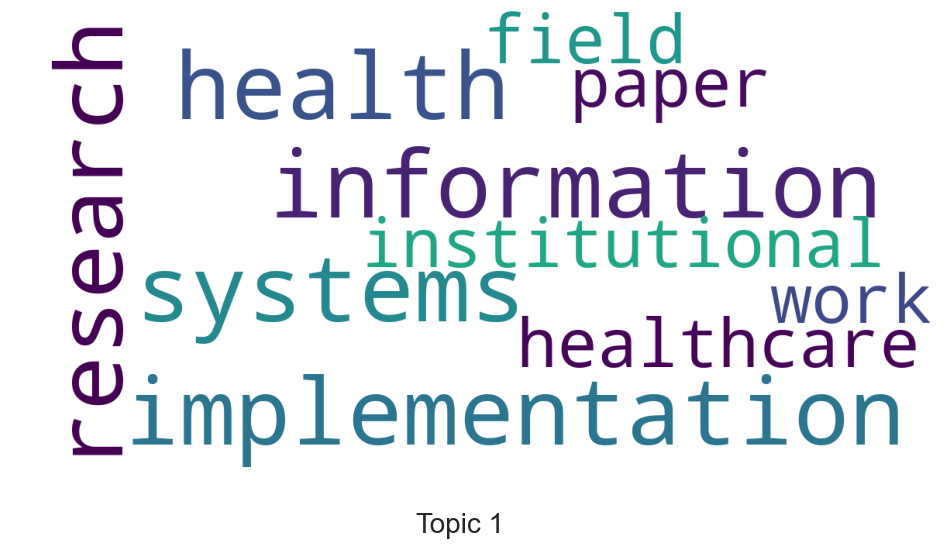

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


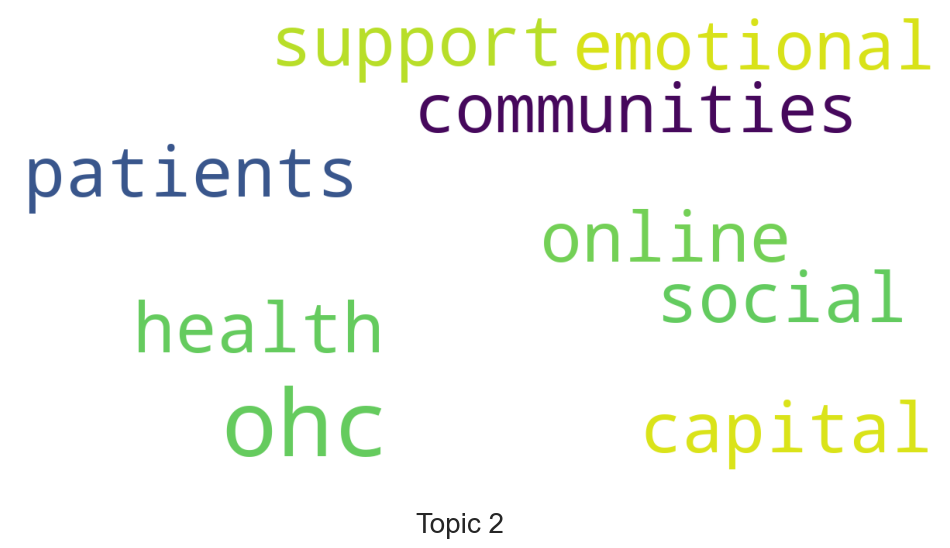

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


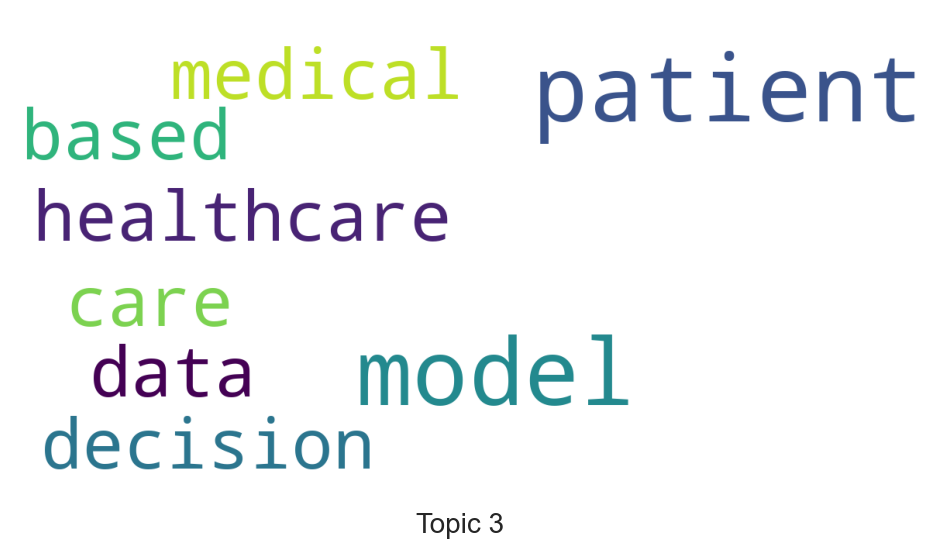

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


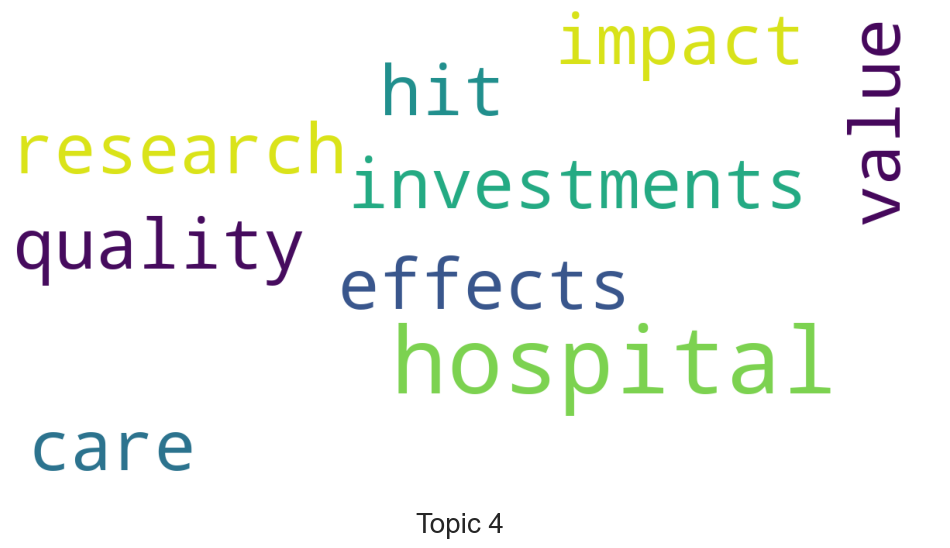

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


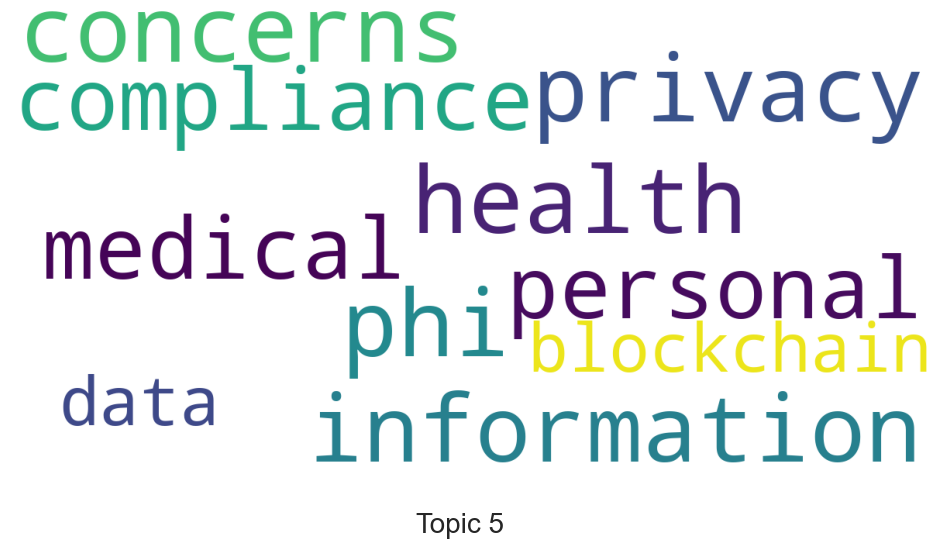

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


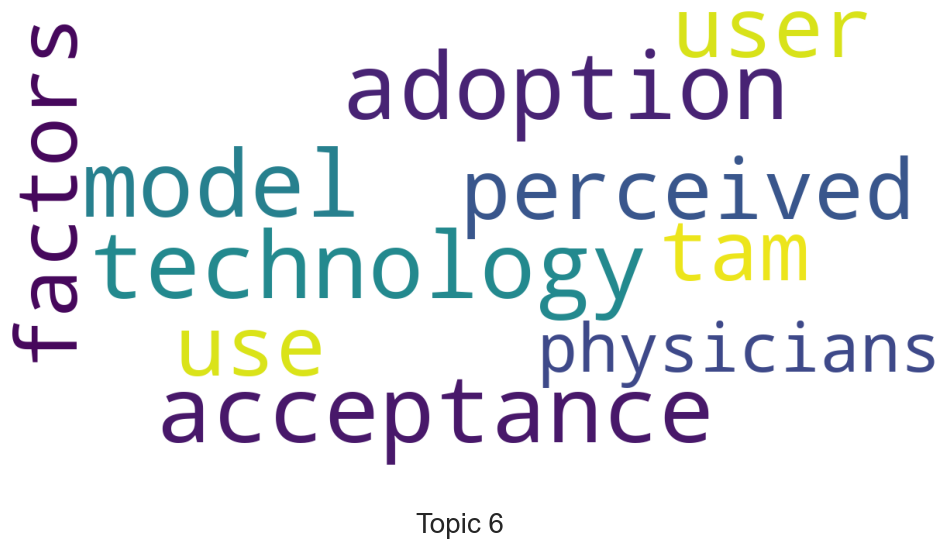

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


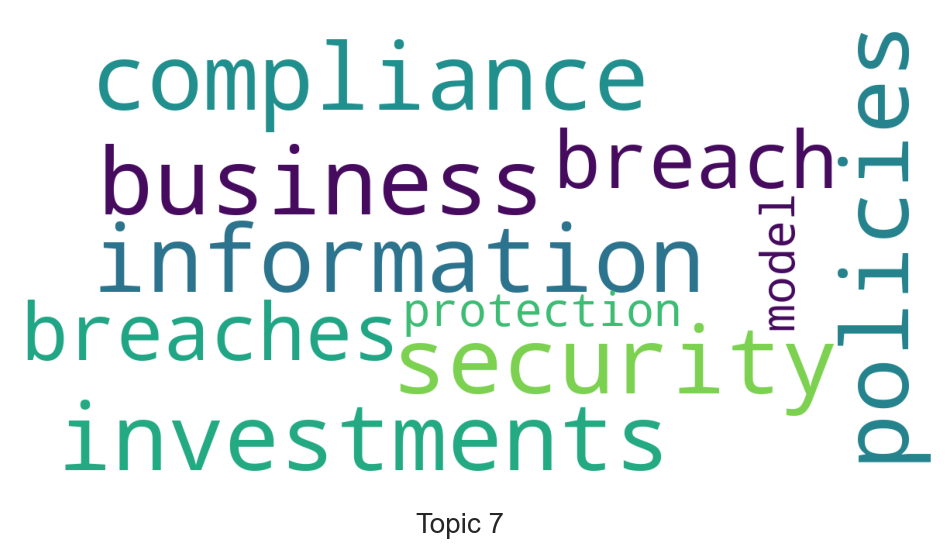

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


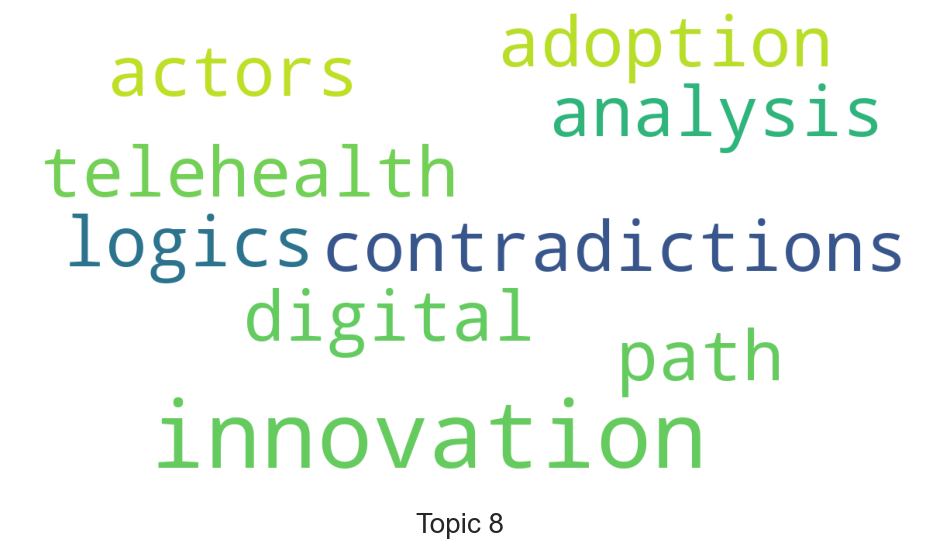

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


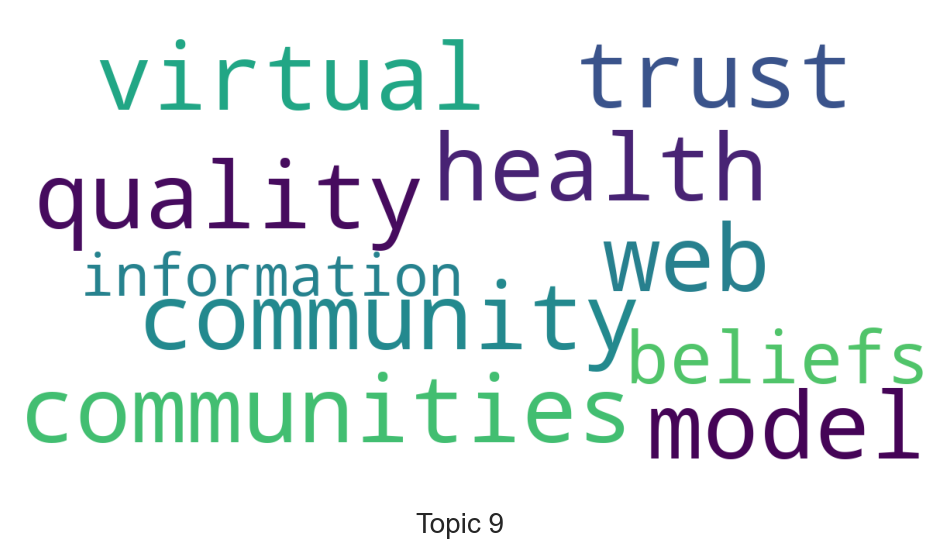

/Users/anikanissen/anaconda3/envs/LDASpacyTransformers/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


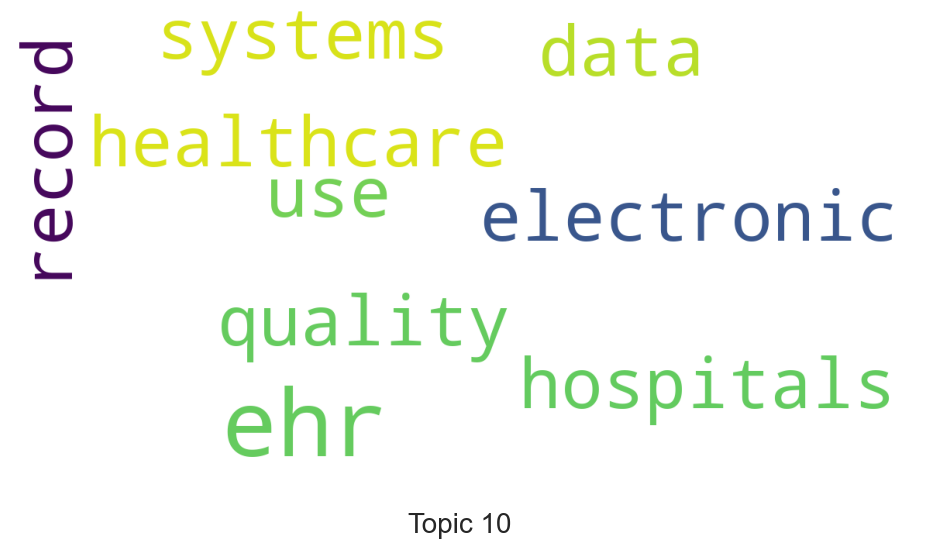

In [90]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)